# Compare Simulated and Analytical Surface Wave Dispersion

> Joseph P. Vantassel, The University of Texas at Austin

This notebooks compares simulated surface wave dispersion determined by transforming simulated waveforms
with the theoretical surface wave dispersion modes determined using the Thomson (1960) - Haskell (1953) Transfer Matrix
analytical solution as implemented by Wathelet (2005). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import swprepostpp
import swprocess
import sigpropy

## The Model

To simulate the waveforms we must define an experimental model. The details of this model are provided below.

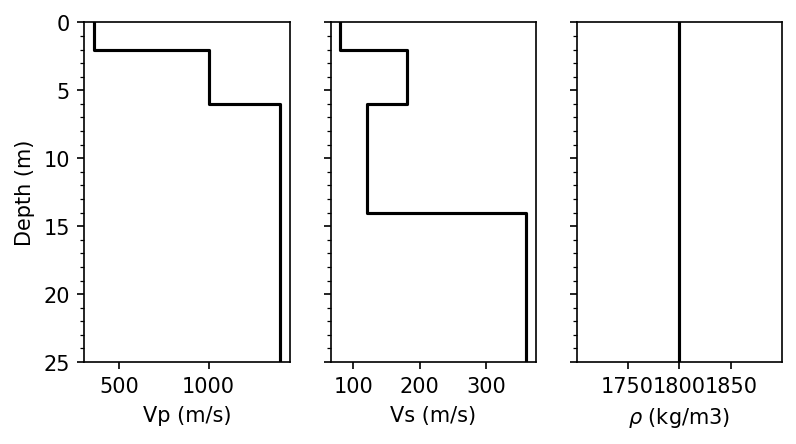

In [2]:
tk = [2, 4, 8, 0]
vp = [360, 1000, 1400, 1400]
vs = [80, 180, 120, 360]
rh = [1800]*4
gm = swprepostpp.GroundModel(thickness=tk, vp=vp, vs=vs, density=rh)

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(6,3), dpi=150)

for ax, par, xlabel in zip(axs, [gm.vp2, gm.vs2, gm.rh2], ["Vp (m/s)", "Vs (m/s)", r"$\rho$"+" (kg/m3)"]):
    ax.plot(par, gm.depth, color="#000000")
    ax.set_xlabel(xlabel)

ax = axs[0]
ax.set_ylabel("Depth (m)")
ax.set_ylim((25,0))
ax.set_yticks(np.arange(0, 25, 1), minor=True)

plt.show()

## Wavelet

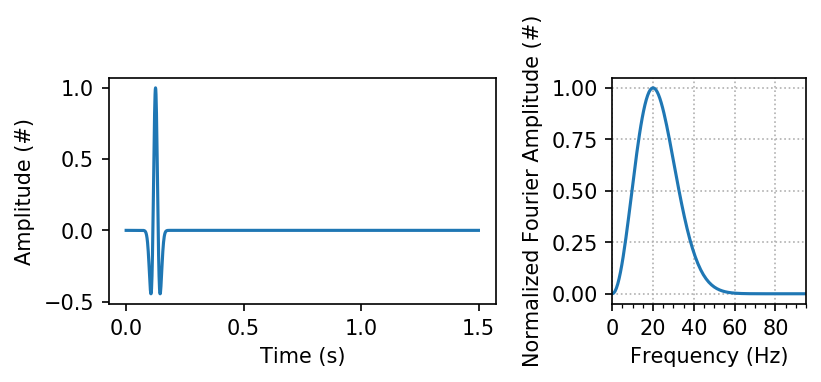

In [3]:
df = pd.read_csv("ricker_fc20hz.csv")
time = df["Time (s)"]
amplitude = df["Amplitude (#)"]
dt = time[1] - time[0]

tseries = sigpropy.TimeSeries(amplitude=amplitude, dt=dt)
fseries = sigpropy.FourierTransform.from_timeseries(tseries)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,2), dpi=150, gridspec_kw=dict(wspace=0.4, width_ratios=[1,0.5]))

ax = axs[0]
ax.plot(tseries.time, tseries.amp)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (#)")

ax = axs[1]
ax.plot(fseries.frq, fseries.mag/np.max(fseries.mag))
ax.set_xlim(0, 80)
ax.set_xticks(np.arange(0,100,20))
ax.set_xticks(np.arange(0,100,5), minor=True)
ax.grid(linestyle=":")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Normalized Fourier Amplitude (#)")

plt.show()

## Analytical Solution

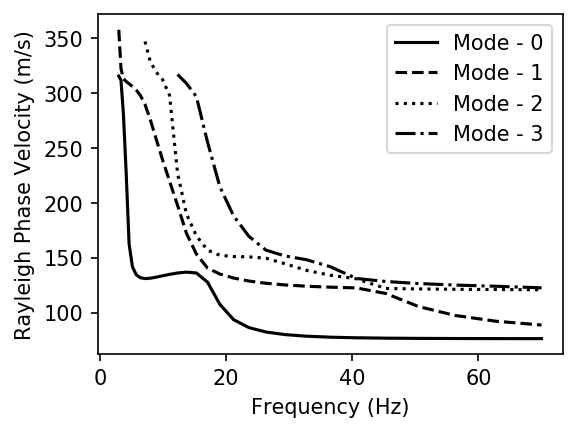

In [4]:
dc_set = gm.calc_dc(gpdc_kwargs={"-R":4, "-min":3, "-max":70, "-n":30})

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

for (model, dc), linestyle in zip(dc_set.rayleigh.items(), ["-", "--", ":", "-."]):
    ax.plot(dc.frequency, dc.velocity, label=f"Mode - {model}", color="#000000", linestyle=linestyle)
ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
ax.set_xlabel("Frequency (Hz)")
ax.legend()
plt.show()

## Compare Simulated and Analytical

Analysis of -> 46mlong_2mspacing_-5moffset.su


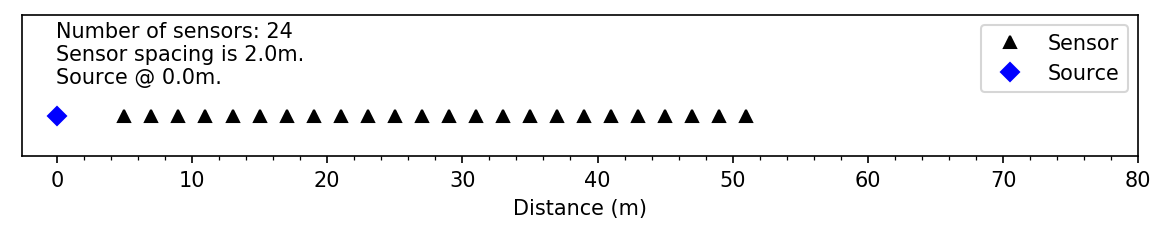

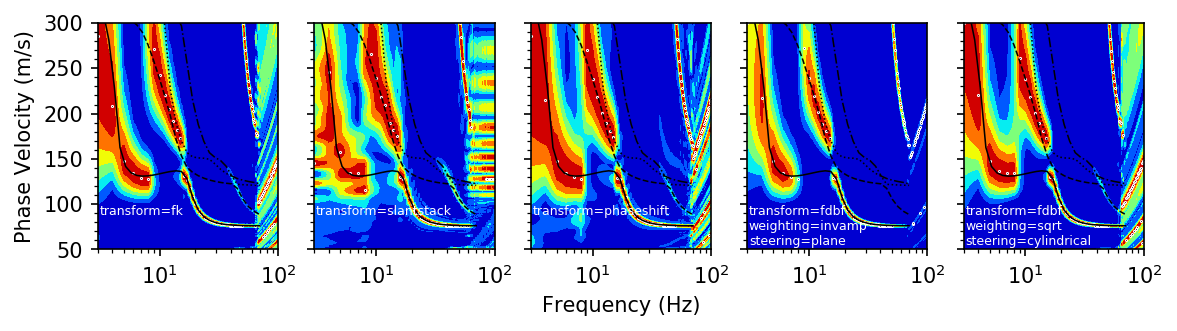





Analysis of -> 46mlong_2mspacing_-10moffset.su


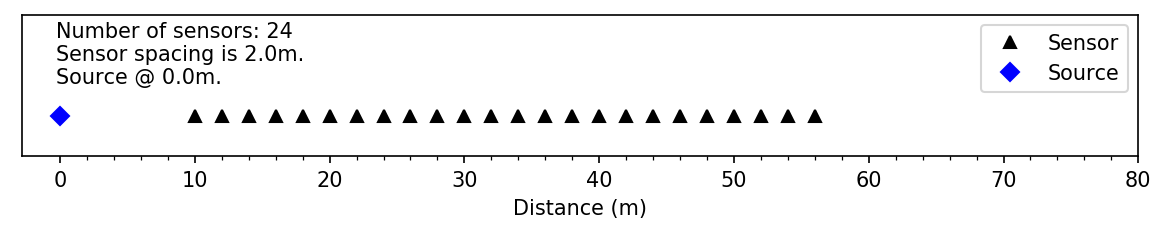

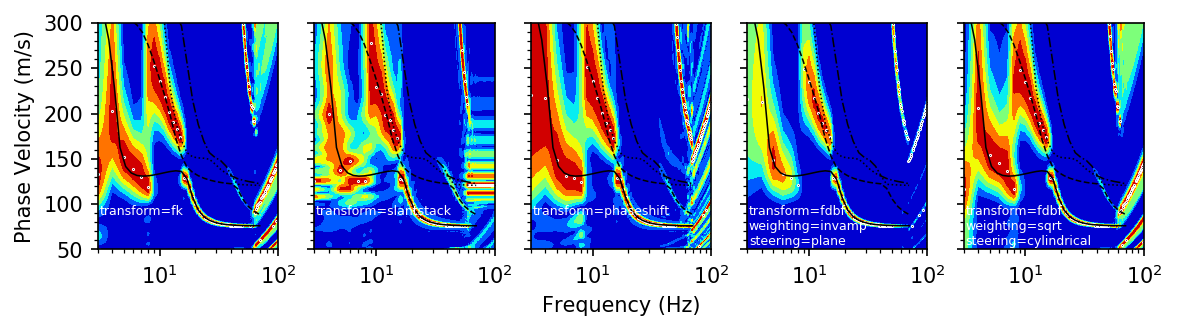





Analysis of -> 46mlong_2mspacing_-20moffset.su


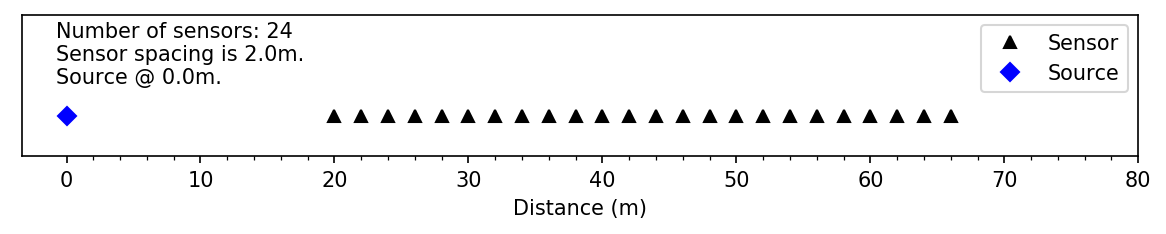

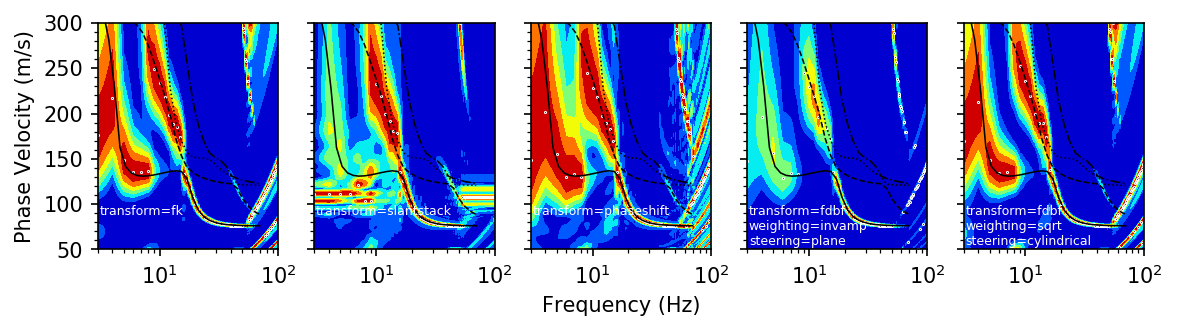





Analysis of -> 60mlong_customspacing_-5moffset.su


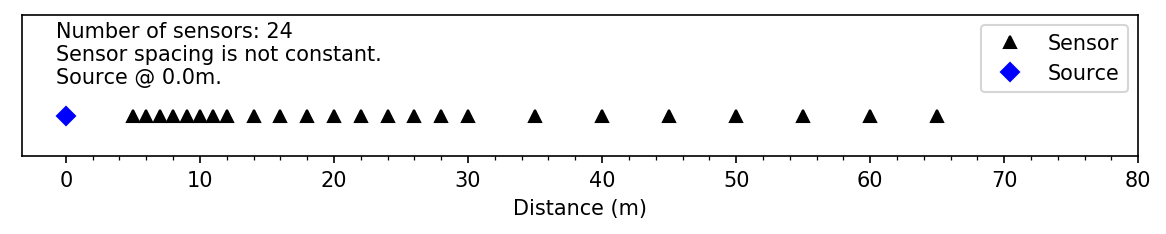

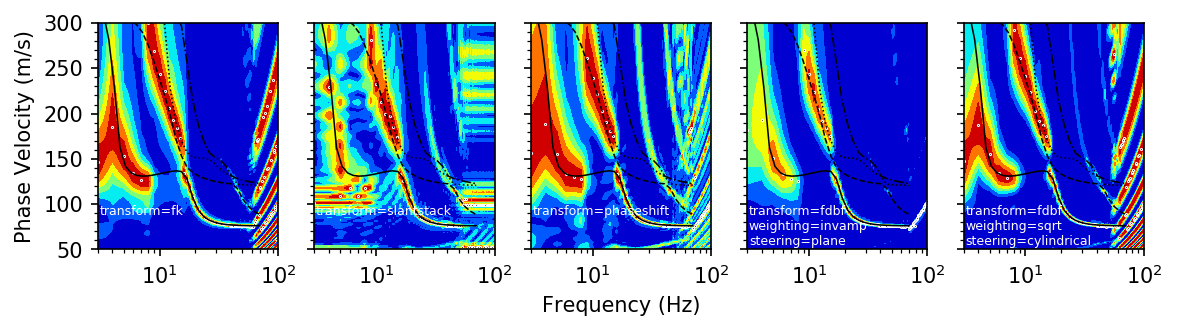





Analysis of -> 60mlong_customspacing_-10moffset.su


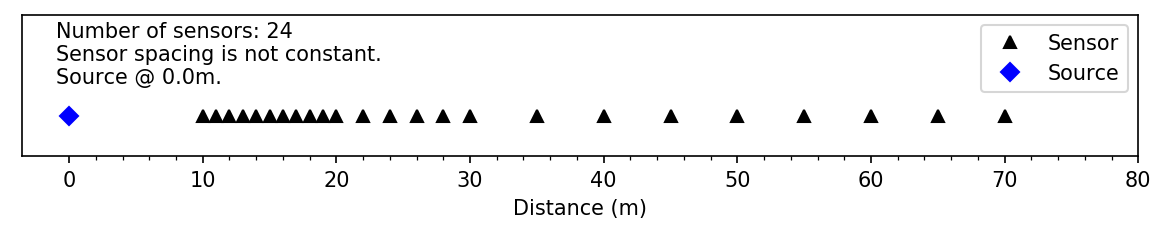

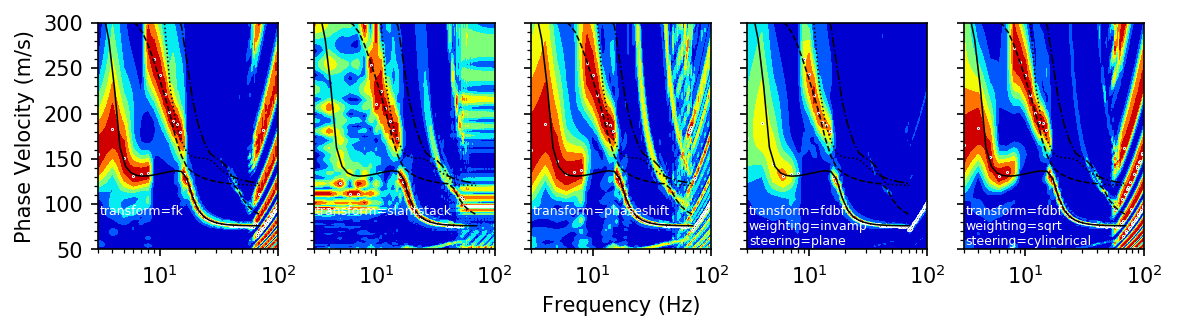

In [5]:
fnames = ["46mlong_2mspacing_-5moffset.su",
          "46mlong_2mspacing_-10moffset.su",
          "46mlong_2mspacing_-20moffset.su",
          "60mlong_customspacing_-5moffset.su",
          "60mlong_customspacing_-10moffset.su"]

vmin, vmax = 50, 300
fmin, fmax = 3, 100
for fname in fnames:
    print(f"Analysis of -> {fname}")
    fig0, axs0 = plt.subplots(figsize=(9.6, 1.25), dpi=150)
    fig1, axs1 = plt.subplots(ncols=5, sharey=True, sharex=True, figsize=(9,2), dpi=150)

    for ax, transform, normalization, weighting, steering in zip(axs1,
                                                  ["fk", "slantstack", "phaseshift", "fdbf", "fdbf"],
                                                  ["frequency-maximum", "frequency-maximum", "frequency-maximum", "absolute-maximum", "frequency-maximum"],
                                                  ["n/a", "n/a", "n/a", "invamp", "sqrt"],
                                                  ["n/a", "n/a", "n/a", "plane", "cylindrical"]):
        
        swprocess.Masw.create_settings_file(fname="tmp.json", transform=transform, weighting=weighting, steering=steering,
                                            vmin=vmin, vmax=vmax, fmin=fmin, fmax=fmax, pad=True, df=1)
        result = swprocess.Masw.run(fnames=fname, settings_fname="tmp.json")
        result.normalize(normalization)
        ax.contourf(result.frequencies, result.velocities, result.power, cmap="jet")
        ax.plot(result.frequencies, result.find_peak_power(),
                marker="o", markersize=0.5, markerfacecolor="#000000", markeredgecolor="#ffffff", linestyle="")
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        if transform == "fdbf":
            text = f"transform={transform}\nweighting={weighting}\nsteering={steering}"
        else:
            text = f"transform={transform}\n\n"
        ax.text(0.01, 0.005, text, ha="left", va="bottom", transform=ax.transAxes, fontsize=6, color="#ffffff")
        

        for (model, dc), linestyle in zip(dc_set.rayleigh.items(), ["-", "--", ":", "-."]):
            ax.plot(dc.frequency, dc.velocity, label=f"Mode - {model}", color="#000000", linestyle=linestyle, linewidth=0.75)
            ax.set_xscale("log")
        
        ax.set_xticks([10,100])
        ax.set_xticks([3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100], minor=True)

        ax.set_yticks(np.arange(vmin, vmax+50, 50))
        ax.set_yticks(np.arange(vmin, vmax+10, 10), minor=True)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        
    axs1[2].set_xlabel("Frequency (Hz)")
    axs1[0].set_ylabel("Phase Velocity (m/s)")
    
    result.array.plot(ax=axs0)
    axs0.set_yticks([])
    axs0.set_xticks(np.arange(0, 90, 10))
    axs0.set_xticks(np.arange(0, 80, 2), minor=True)
    
    plt.show()
    print("\n\n\n")